Initial Setup

In [3]:
import sys
sys.path.append('Libraries/')
import pclpy
import cv2
import numpy as np
import pdal
import segTree
import Visualization
import Utils
import pandas as pd
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
import Tree_Tool

#Utils
def tic():
    global timestart
    timestart = time.perf_counter()
    
def toc():
    global timestart
    return time.perf_counter()-timestart

ModuleNotFoundError: No module named 'Visualization'

Load the point cloud from a .pcd using pclpy, we use our function segTree which containes many helper funcions such as voxelize to down sample our point cloud and visualize using our Visualization function built on open3d

In [ ]:
PointCloud = pclpy.pcl.PointCloud.PointXYZ()
pclpy.pcl.io.loadPCDFile('path_to_point_cloud/downsampledlesscloudEURO1.pcd',PointCloud)
PointCloudV = segTree.voxelize(PointCloud.xyz,0.04)
Visualization.open3dpaint(PointCloudV, reduce_for_Vis = True )

Tree tool is our main class that containes the routines for tree detection and DBH extraction

In [ ]:
Mysegmentor = Tree_Tool.Tree_tool(PointCloudV)

Our tree top object has a series of funtions that are performed to obtain DBH and tree detection.

In [ ]:
Mysegmentor.Step_1_Remove_Floor()

Visualization.open3dpaint([Mysegmentor.NongroundCloud,Mysegmentor.GroundCloud],reduce_for_Vis = True )

Set Algorithm Parameters

In [6]:
Mysegmentor.set_Ksearch(0.08)

Run main process

In [8]:
#Get point normals for filtering
Mysegmentor.Step_2_Normal_Filtering()
Visualization.open3dpaint([Mysegmentor.NongroundCloud.xyz, Mysegmentor.nonFilteredpoints.xyz + Mysegmentor.nonFilterednormals * 0.1,
                          Mysegmentor.nonFilteredpoints.xyz + Mysegmentor.nonFilterednormals * 0.2],reduce_for_Vis = True )

Visualization.open3dpaint([Mysegmentor.filteredpoints.xyz , Mysegmentor.filteredpoints.xyz + Mysegmentor.filterednormals * 0.05,
                          Mysegmentor.filteredpoints.xyz + Mysegmentor.filterednormals * 0.1],reduce_for_Vis = True )

In [9]:
Mysegmentor.Step_3_Eucladean_Clustering()
Visualization.open3dpaint(Mysegmentor.cluster_list,reduce_for_Vis = True )

In [10]:
#Group stem segments
Mysegmentor.Step_4_Group_Stems()
            
Visualization.open3dpaint(Mysegmentor.complete_Stems,reduce_for_Vis = True )

In [11]:
Mysegmentor.Step_5_Get_Ground_Level_Trees()

Visualization.open3dpaint(Mysegmentor.lowstems,reduce_for_Vis = True )

In [12]:
Mysegmentor.Step_6_Get_Cylinder_Tree_Models()

Visualization.open3dpaint([i['tree'] for i in Mysegmentor.finalstems] + Mysegmentor.stemcyls,reduce_for_Vis = True )
     

Load Cloud and visualize

Use PDAL to apply a Morphological Filter to seperate ground and non ground points

In [13]:
PointCloud = pclpy.pcl.PointCloud.PointXYZ()
pclpy.pcl.io.loadPCDFile('D:/Documentos/ParaAutonomia/Python/Proyecto/Data/NistClouds/downsampledlesscloudEURO3.pcd',PointCloud)
PointCloudV = segTree.voxelize(PointCloud.xyz,0.05)
Visualization.open3dpaint(PointCloudV, reduce_for_Vis = True )

In [28]:
Mysegmentor.set_pointcloud(PointCloudV)

In [29]:
Mysegmentor.Full_Process()

Step_1_Remove_Floor
Step_2_Normal_Filtering
Step_3_Eucladean_Clustering
Step_4_Group_Stems
Step_5_Get_Ground_Level_Trees
Step_6_Get_Cylinder_Tree_Models
Done


In [33]:
#####################################################
#Get ground truth
treedata = pd.read_csv('D:/Documentos/ParaAutonomia/Python/Proyecto/Data/EuroSDR_DataRelease/EuroSDR_DataRelease/TLS_Benchmarking_Plot_3_LHD.txt',sep = '\t',names = ['x','y','height','DBH'])
Xcor,Ycor,diam = treedata.iloc[0,[0,1,3]]
surtreesL1 = [Utils.makecylinder(model=[Xcor, Ycor, 0,0,0,1,diam/2],length=10,dense=20)]
Zcor = 0
TreeDict = [np.array([Xcor,Ycor,diam])]
for i,rows in treedata.iloc[1:].iterrows():
    Xcor,Ycor,diam = rows.iloc[[0,1,3]]
    if not np.any(np.isnan([Xcor,Ycor,diam])):
        surtreesL1.append(Utils.makecylinder(model=[Xcor, Ycor, 0,0,0,1,diam/2],length=10,dense=10))
        TreeDict.append(np.array([Xcor,Ycor,diam]))
surtrees1 = [p for i in surtreesL1 for p in i]
surtreesCloud1 = pclpy.pcl.PointCloud.PointXYZ(surtrees1)

#DataBase
#Found trees
#Hungarian Algorithm assignment
CostMat = np.ones([len(TreeDict),len(Mysegmentor.stemcyls)])
for X,datatree in enumerate(TreeDict):
    for Y,foundtree in enumerate(Mysegmentor.finalstems):
        CostMat[X,Y] = np.linalg.norm([datatree[0:2]-foundtree['model'][0:2]])

dataindex, foundindex = linear_sum_assignment(CostMat,maximize=False)

#Get metrics
locationerror = []
correctlocationerror = []
diametererror = []
cloudmatch = []
for i,j in zip(dataindex, foundindex):
    locationerror.append(np.linalg.norm((Mysegmentor.finalstems[j]['model'][0:2]-TreeDict[i][0:2])))
    if locationerror[-1]<0.6:
        diametererror.append(abs(Mysegmentor.finalstems[j]['model'][6]*2-TreeDict[i][2]))        
        correctlocationerror.append(np.linalg.norm((Mysegmentor.finalstems[j]['model'][0:2]-TreeDict[i][0:2])))
    cloudmatch.append(np.vstack([surtreesL1[i],Mysegmentor.finalstems[j]['tree'],Mysegmentor.stemcyls[j]]))

#PCA filtering and Eucladian Clustering
Visualization.PCL3dpaint(cloudmatch)

In [34]:
n_ref = len(TreeDict)
n_match = (len(diametererror))
n_extr = len(locationerror) - n_match

Completeness = n_match/n_ref
Correctness = n_match/(n_extr+n_match)

Total number of trees in Ground Truth:  148
Total number of trees matched with Ground Truth:  79
Total number of trees extra trees found:  1
Percentage of matched trees:  53 %
Percentage of correctly matched trees:  99 %


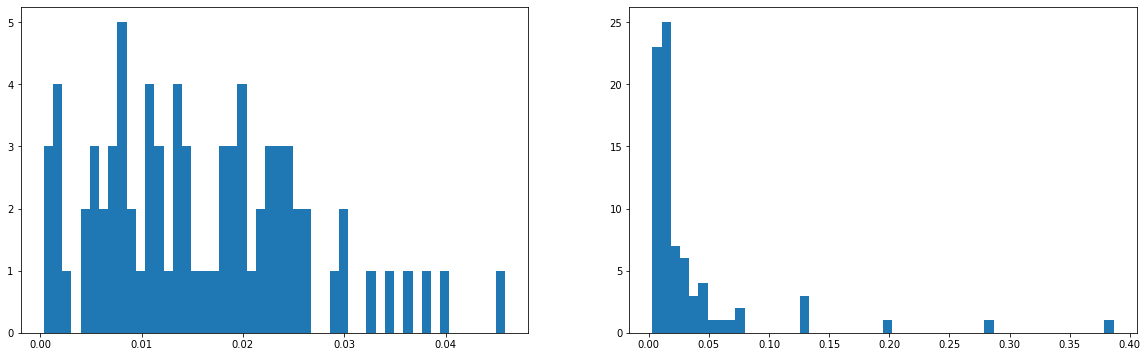

In [35]:
plt.figure(figsize = (20,6))
plt.subplot(1,2,1)
plt.hist(diametererror,50)
plt.subplot(1,2,2)
plt.hist(correctlocationerror,50)
print('Total number of trees in Ground Truth: ', n_ref)
print('Total number of trees matched with Ground Truth: ', n_match)
print('Total number of trees extra trees found: ', n_extr)

print('Percentage of matched trees: ', round(Completeness*100), '%')
print('Percentage of correctly matched trees: ', round(Correctness*100), '%')